# Analysing Auction Performance
This notebook contains the code required to conduct a Bayesian data analysis on data collected from a set of multiple-lot online auction events executed in Europen markets, over the past year. We will build interpretable models of the average Return-on-Reserve (RoR), using variables that describe various facets of multiple-lot online auction events - e.g. the average number of bidders per-lot.

The ultimate aim of this endeavour is for this notebook (and it's surrounding directory structure) to serve as a template workflow for conducting an end-to-end Bayesian data analysis using PyMC3. It includes many helper functions for automating otherwise tedious tasks (e.g. interacting with Theano to score models on test data) and examples of how data pre-processing can be integrated with Scikit-Learn. The overall approach has been heavily inspired by the book 'Statistical Rethinking - a Bayesian Course with Examples in R and Stan', by Richard McElreath http://xcelab.net/rm/statistical-rethinking/, which is the most significant book on statistics and modelling that I have read during a career spanning more than a decade. Credit also goes to 'Bayesian Data Analysis', by Andrew Gelman & Co. http://www.stat.columbia.edu/~gelman/book/.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt


## Load Data and Yield Pandas DataFrame
Load the auction data from CSV file and take a glimpse. In practice, the data need not be in CSV format and could be collected via Spark and then transformed to a Pandas DataFrame directly from a Spark DataFrame, etc.

In [2]:
auction_eval = pd.read_csv('../data/auction_data.csv')

auction_eval.info()
auction_eval.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6220 entries, 0 to 6219
Data columns (total 10 columns):
auction_id       6220 non-null int64
RoR              6220 non-null float64
STR              6220 non-null float64
BPL              6220 non-null float64
lots             6220 non-null int64
product_types    6220 non-null float64
avg_reserve      6220 non-null float64
avg_start_bid    6220 non-null float64
auction_mech     6220 non-null object
country          6220 non-null object
dtypes: float64(6), int64(2), object(2)
memory usage: 486.0+ KB


,auction_id,RoR,STR,BPL,lots,product_types,avg_reserve,avg_start_bid,auction_mech,country
0,1324,0.984284,0.035471,11.066667,45,0.822222,22090.283008,0.000000,EnglishForward,TR
1,1325,0.000000,0.000000,11.000000,52,0.634615,18758.711989,0.000000,EnglishForward,TR
2,1326,0.774436,0.723315,7.000000,4,1.000000,9593.157715,0.161214,EnglishForward,CZ
3,1327,0.933634,0.822529,17.464286,28,0.857143,16195.701695,0.000000,EnglishForward,EU
4,1328,0.957757,0.963006,11.487179,39,0.820513,8733.333333,0.000000,EnglishForward,EU


### Data Description
- **auction_id** - unique identifier for a single multi-lot online auction event;
- **RoR** - the average Return-on-Reserve for successfully sold lots in the multi-lot online auction event, computed as realised price divided by reserve price;
- **STR** - the proportion of lots (by value) that were successfully sold in the auction event;
- **lots** - the number of lots offered in the multi-lot online auction event;
- **product_types** - the number of different product types offered in the multi-lot online auction event;
- **avg_reserve** - the average reserve price over all lots in the multi-lot online auction event
- **avg_start_bid** - the average starting-bid (expressed as a fraction of the reserve bid), over all lots in the multi-lot online auction event
- **BPL** - the average number of bidders per-lot;
- **auction_mech** - the auction mechanism used for the auction event (one of English Forward, Sealed Bid or Fixed Price); and,
- **country** - the local market running the auction.

### Initial Variable Selection
We choose the following variables to use for trying to understand and predict RoR:
- **lots** - with the aim for controlling for the presence of available alternatives;
- **avg_reserve** - to control for lot value - e.g. lower value lots may see more bidders willing to go above the reserve and vice-versa;
- **avg_start_bid** - to control for the presence of a public price signal (we may need to derive this);
- **BPL** - we know from basic auction theory, that the more bidders there are, then the better the expected prices will be;
- **auction_mech** - whether the lots were traded via English Forward (EF) or Sealed Bid (SB) auctions; and,
- **country** - to control for differences between local markets.

In [3]:
RoR = ['RoR']
model_vars = ['lots', 'avg_reserve', 'avg_start_bid',
              'BPL', 'auction_mech', 'country']


The section below explores the data in greater detail - to get straight to the modelling head to the section titles '**Modelling RoR using Bayesian Inference**'.

## Data Exploration

Through visualisation and descriptive statistics we try to understand the characteristics of the individual variables that are available for using to predict RoR.

### Descriptive Statistics

In [4]:
auction_eval[RoR + model_vars].head()


,RoR,lots,avg_reserve,avg_start_bid,BPL,auction_mech,country
0,0.984284,45,22090.283008,0.000000,11.066667,EnglishForward,TR
1,0.000000,52,18758.711989,0.000000,11.000000,EnglishForward,TR
2,0.774436,4,9593.157715,0.161214,7.000000,EnglishForward,CZ
3,0.933634,28,16195.701695,0.000000,17.464286,EnglishForward,EU
4,0.957757,39,8733.333333,0.000000,11.487179,EnglishForward,EU


### Outlier Removal and other Dataset Filtering
Some outliers have obviously still found their way into the data. So, we will limit our modelling dataset by filtering-out values that don't feel correct based on our knowledge of the data (and the issues embedded within it). As such, we will filter-out the top percentile of RoR values as we know there is ambiguity surrounding reserve prices. Likewise, we have spotted auction events with average reserve prices in the millions of Euros, so we will filter-out the top percentile of mean reserve price observations, as well.

We will also exclude Fixed Price (FP) auction events from the dataset as the RoR for these auction events is fixed at 1 and all auction events where nothing was sold and nothing can be said about price and RoR (i.e. where auction revenue = 0).

In [5]:
ptile_thold = 0.99

model_data = (
    auction_eval
    .loc[
        (auction_eval['RoR'] > 0)
        & (auction_eval['auction_mech'] != 'FixedPrice')
        & (auction_eval['RoR'] < auction_eval['RoR'].quantile(ptile_thold))
        & (auction_eval['avg_reserve']
           < auction_eval['avg_reserve'].quantile(ptile_thold)), :]
    .assign(
        country=auction_eval['country'].apply(lambda x: 'country_' + x),
        auction_mech=(
            auction_eval['auction_mech'].apply(lambda x: 'auction_mech_' + x)))
    [RoR + model_vars])

desc_vars = ['auction_id']

model_data.describe()


,RoR,lots,avg_reserve,avg_start_bid,BPL
count,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.989743,48.491018,11099.072681,0.205143,8.251535
std,0.140135,39.081027,4910.386793,0.390067,4.722761
min,0.052569,1.000000,400.000000,0.000000,1.000000
25%,0.921498,17.000000,7378.053377,0.000000,3.833333
50%,1.000367,40.000000,10218.566667,0.000000,8.700000
75%,1.041915,74.000000,13731.054182,0.000000,11.673864
max,1.617087,516.000000,30198.234375,1.000000,36.000000


### RoR
Starting by reminding ourselves of the distributional characteristics of RoR.

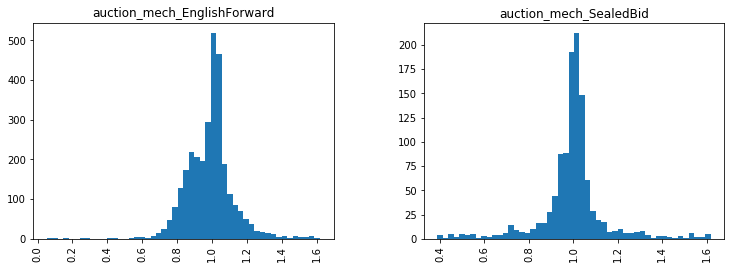

In [6]:
_ = (model_data[RoR + ['auction_mech']]
     .hist(by='auction_mech', bins=50, figsize=(12, 4)))


- EF auctions appear to have a bi-model distribution, suggesting conditioning on independent variables; and,
- SB auctions appear to have 'fat tails' - i.e. a Student-T likelihood function may be worth considering.

We now take a deeper look into EF auctions and the distribution of RoR by whether or not start bids were used.

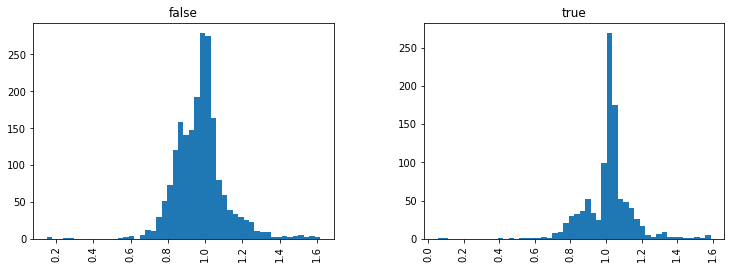

In [7]:
_ = (model_data
     .query('auction_mech == "auction_mech_EnglishForward"')
     .assign(has_start_bids=auction_eval['avg_start_bid']
             .apply(lambda x: 'true' if x > 0 else 'false'))
     [RoR + ['has_start_bids']]
     .hist(by='has_start_bids', bins=50, figsize=(12, 4)))


Some of the bi-modality in RoR does appear to originate from the presence of start bids (above left). This sub-distribution is, however, also bi-model so all of our question have not been answered. We continue to dig-in to this and look at a scatter plot of RoR vs. avg_start_bid to see if the magnitude of the start bids plays a part in what we are observing.

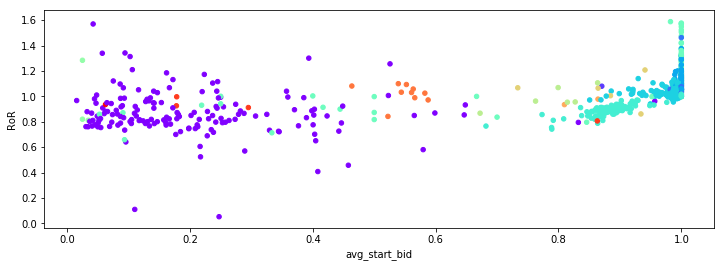

In [8]:
start_bid_analysis = (
    model_data
    .query('auction_mech == "auction_mech_EnglishForward"')
    .query('avg_start_bid > 0'))

_ = (start_bid_analysis
     .plot('avg_start_bid', 'RoR', kind='scatter',
           c=start_bid_analysis['country'].factorize()[0], cmap='rainbow',
           colorbar=False, figsize=(12, 4)))


Based on the above plot, it appears that there are some countries that are setting start bids that are greater-than-or-equal to the reserve price, which cannot be true. Thus, we will will filter-out these data points before we start modelling in earnest.

There are 261 observations with spurious start bid (and hence reserve price) data to filer-out.


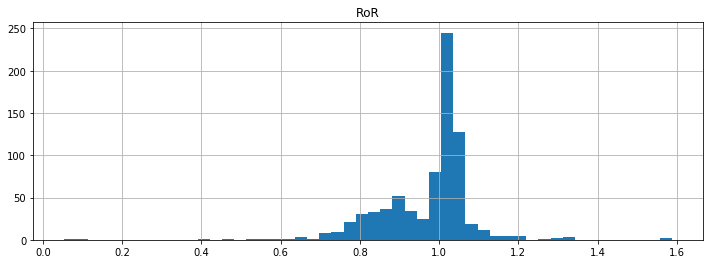

In [9]:
print("""There are {} observations with spurious start bid (and hence reserve
      price) data to filer-out."""
      .format(model_data.query('avg_start_bid >= 1').shape[0]))

_ = (start_bid_analysis
     .query('avg_start_bid < 1')
     [RoR]
     .hist(bins=50, figsize=(12, 4)))


We can, however, see from the filtered distribution above that the bi-modality is still present. With recourse to the scatter plot above, we can see that the bi-modality is country-related, which justifies the choice of country as a potential explanatory variable that we may need to control for (or condition on).

### Independent Variables
We now turn our attention to the distributional characteristics of each potential numerical modelling variable.

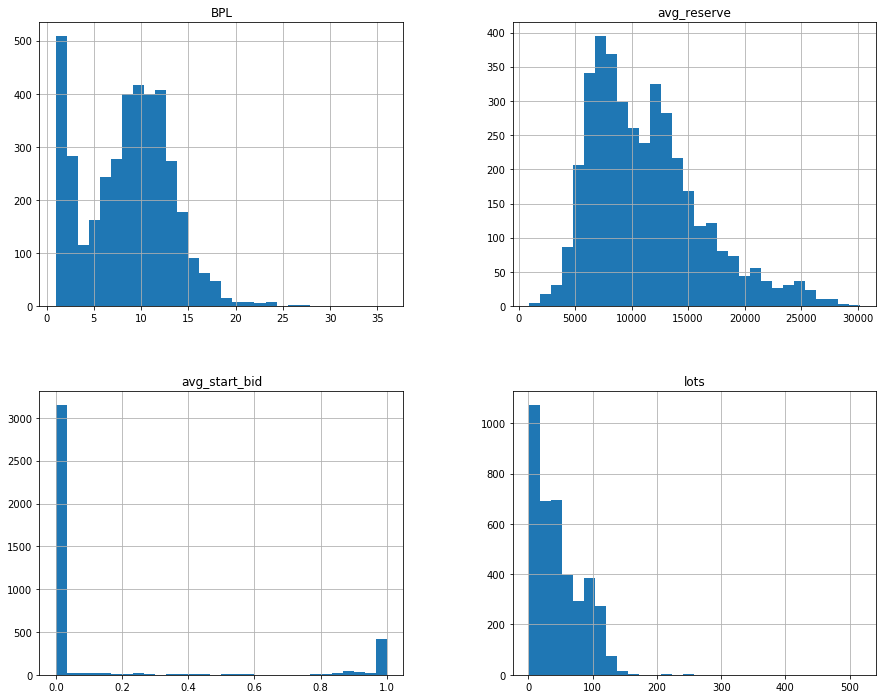

In [10]:
_ = (model_data[model_vars]
     .query('avg_start_bid < 1')
     .hist(bins=30, figsize=(15, 12)))


### Dependency Structure and Correlations
Taking a superficial look at variate-by-variate scatter plots and Pearson correlations between RoR and the initial modelling variables, for a single country ('EU' - the pan-European online market), and trading mechanism (English Forward). We have deliberately looked at a specific (conditioned) slice through the data as it will be representative of the kinds of models we will build using the categorical data and because visually, different relationships relating to the different market structures and dynamics associated with different entities and mechanisms, will not obfuscate any pattern.

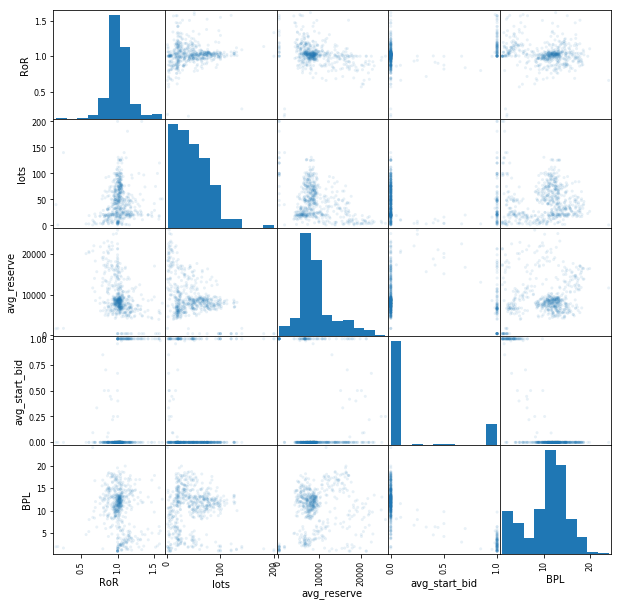

In [11]:
_ = pd.plotting.scatter_matrix(
    (model_data[RoR + model_vars]
     .query('country == "country_EU"')
     .query('auction_mech == "auction_mech_EnglishForward"')),
    figsize=(10, 10), alpha=0.1)


In [12]:
model_data[RoR + model_vars].corr()


,RoR,lots,avg_reserve,avg_start_bid,BPL
RoR,1.000000,0.069050,-0.072248,0.175049,-0.070454
lots,0.069050,1.000000,-0.013865,0.365629,-0.150326
avg_reserve,-0.072248,-0.013865,1.000000,-0.000236,-0.142450
avg_start_bid,0.175049,0.365629,-0.000236,1.000000,-0.617774
BPL,-0.070454,-0.150326,-0.142450,-0.617774,1.000000


Initial thoughts on the choice of modelling variables:
- **avg_start_bid** should be mapped to a categorical variable 'has_start_bid' as it is almost binary;
- neglecting **avg_start_bid**, there doesn't appear to be any obvious sources of multi-collinearity - via 'post-treatment bias', or otherwise - that could interfere with model interpretation .

## Modelling RoR using Bayesian Inference
Whereas in the past we have trained multiple ML algorithms when the ultimate aim was prediction, we are currently focused more on statistical learning, model interpretation and modelling real-world economic phenomena - than we are on prediction accuracy. Hence, we will concentrate our efforts on using a single approach - estimating linear regression models using Bayesian inference techniques.

### Data Preparation Pipeline
We define data transformation pipelines to:
- select the variables of interest;
- center and scale the continuous variables; 
- handling categorical features in a way that makes sense for our models - e.g. encoding factors (or levels) as opposed to one-hot encoding; and,
- use a log-transform on the dependent variable (using a separate pipleine for this variable as in production we would be predicting this variable and would not have access to it).

The motivation for centering and scaling the data is threefold:
1. the numerical routines required for computing MAP estimates and posterior distribution samples are more stable when all of the input variates have the same scale (i.e. the same units);
2. centering the variates so that the mean level corresponds to 0 makes it easy to isolate the impact that just one independent variable (e.g. lots), has on the dependent variable (i.e. RoR), by setting all other variables to 0 (i.e. their mean level); and,
3. both centering and scaling the variables by the standard deviation leads to easy interpretation and comparison of parameters estimates - e.g a parameter estimate is 1, then we know that when the independent variable (e.g. lots), is 1 standard deviation above the mean, then it will impact the dependent variable (i.e. RoR), by precisely 1.

The motivation for using a log-transform:
- RoR is bounded in the range $(0, \infty]$, by construction;
- we intend to use maximum entropy distributions (e.g. Normal) as likelihood functions, but these are defined with support on $[-\infty, \infty]$; so,
- by defining the following transformation of RoR, $y = f(\text{RoR}) =  \ln(\text{RoR})$, we can use a maximum entropy distributions as likelihood functions, with confidence that they are correctly expressing the uncertainty in the transformed dependent variable, $y$.

In [13]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (StandardScaler, LabelEncoder,
                                   FunctionTransformer)


def cat_col_selector(df):
    df_cat = df.select_dtypes(include=['object'])
    return df_cat.values


def num_col_selector(df):
    df_num = df.select_dtypes(exclude=['object'])
    return df_num.values


def cat_col_str2fact(X):
    fact_cols = [LabelEncoder().fit_transform(col) for col in X.T]
    fact_mat = np.vstack(fact_cols)
    return fact_mat.T


def cat_col_fact_names(df):
    def list_of_fact_names(col):
        fact_names = LabelEncoder().fit(col).classes_
        return fact_names.tolist()
    df_cat = df.select_dtypes(include=['object'])
    X = df_cat.values
    fact_name_cols = [(col_name, list_of_fact_names(col))
                      for col_name, col in zip(df_cat.columns, X.T)]
    return dict(fact_name_cols)


def make_new_vars(df):
    start_bid_map = (
        lambda x: 'start_bids_true' if x > 0 else 'start_bids_false')
    new_df = df.assign(start_bids=df['avg_start_bid'].apply(start_bid_map))
    return new_df


# pipline for independent variables
ivar_data_pipe = Pipeline([
    ('make_new_vars', FunctionTransformer(make_new_vars, validate=False)),
    ('union', FeatureUnion([
        ('num_vars', Pipeline([
            ('get_num_vars',
             FunctionTransformer(num_col_selector, validate=False)),
            ('scale_vars', StandardScaler())
        ])),
        ('cat_vars', Pipeline([
            ('get_cat_vars',
             FunctionTransformer(cat_col_selector, validate=False)),
            ('factorise',
             FunctionTransformer(cat_col_str2fact, validate=False))
        ]))
    ]))
])

# piplines for dependent variable
dvar_data_pipe = Pipeline([
    ('log', FunctionTransformer(np.log, np.exp, validate=False))])

dvar_itfm = dvar_data_pipe.inverse_transform

# get variable names
num_var_names = (
    make_new_vars(model_data[model_vars])
    .select_dtypes(exclude=['object'])
    .columns
    .tolist())

cat_var_names = (
    make_new_vars(model_data[model_vars])
    .select_dtypes(include=['object'])
    .columns
    .tolist())

all_var_names = num_var_names + cat_var_names

# get levels for categorical data
cat_col_levels = cat_col_fact_names(make_new_vars(model_data[model_vars]))

# perform transformations
y = (dvar_data_pipe
     .fit_transform(model_data['RoR'])
     .values
     .reshape(-1, ))

X = (ivar_data_pipe
     .fit_transform(model_data[model_vars]))

X_df = pd.DataFrame(X, columns=all_var_names)
X_df.head()


,lots,avg_reserve,avg_start_bid,BPL,auction_mech,country,start_bids
0,-0.089338,2.238627,-0.525979,0.596149,0.0,24.0,0.0
1,-1.138566,-0.306716,-0.112631,-0.265032,0.0,5.0,1.0
2,-0.524384,1.038053,-0.525979,1.950946,0.0,8.0,0.0
3,-0.242884,-0.481840,-0.525979,0.685199,0.0,8.0,0.0
4,1.215799,-0.037788,1.706146,-0.847389,0.0,1.0,1.0


### Partition Data into Test and Train Sets
We select 20% of the available observations to hold-back from training our model on, so that their out-of-sample performance can be tested along side other measures of Out-Of-Sample (OOS) predictive accuracy, such as WAIC.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print('{} samples in training dataset and {} samples in test dataset'
      .format(X_train.shape[0], X_test.shape[0]))


3340 samples in training dataset and 835 samples in test dataset


### Define Experimental Setup
In addition to assessing competing models using Bayesian information criteria (e.g. WAIC), we would also like to understand the Root-Mean-Squared-Error (RMSE) of RoR predictions, both in-sample and out-of-sample (due to its ubiquitous use in machine learning model evaluation). The helper function below facilitates this analysis. 

In [15]:
def model_performance(y_, trace_, model_, samples_=500, intvl=0.95,
                      y_inv_tfm=None):

    # if no inverse has been provided use identity
    f = (lambda x: x) if y_inv_tfm is None else y_inv_tfm

    # compute two-sided percentiles for range
    intvl_lwr = (1 - intvl) / 2
    intvl_upr = intvl_lwr + intvl

    # generate samples from the posterior predictive distribution
    # use the expected value as the final prediction
    post_pred_samp = pm.sample_ppc(trace_, model=model_, samples=samples_)
    pred = f(post_pred_samp['Y_obs'].mean(axis=0))

    # compute prediction ranges
    pred_range_lwr = np.percentile(
        f(post_pred_samp['Y_obs']), 100*intvl_lwr, axis=0)
    pred_range_upr = np.percentile(
        f(post_pred_samp['Y_obs']), 100*intvl_upr, axis=0)

    # compute error on model scale
    actual = f(y_)
    error = pred - actual

    # compute deviance using lppd
    waic = pm.stats.waic(trace_, model_, progressbar=True)
    deviance = waic.WAIC - waic.p_WAIC

    # observations in prediction range
    in_range = ((actual > pred_range_lwr)
                & (actual < pred_range_upr)).astype('int')

    # assemble results
    performance_data = np.concatenate([
        pred.reshape((-1, 1)), actual.reshape((-1, 1)), error.reshape((-1, 1)),
        pred_range_lwr.reshape((-1, 1)), pred_range_upr.reshape((-1, 1)),
        in_range.reshape((-1, 1))],
        axis=1)

    # print metrics and return
    print('RMSE = {}'.format(np.sqrt(np.mean(error ** 2))))
    print('Deviance = {}'.format(deviance))
    print('% observations in {}% prediction range = {}'
          .format(100 * intvl, 100 * np.sum(in_range) / in_range.shape[0]))

    df = pd.DataFrame(
        performance_data,
        columns=['predicted', 'actual', 'error', 'predicted_lwr',
                 'predicted_upr', 'in_range'])
    return df


### Map Data to Model Variables
To make the model specification easier to read and to facilitate prediction with PyMC3, we explicitly map data columns to their own name. We also explicitly define them as variables in Theano, whose values can be changed, for example, when need to load test data after estimating on training data (see http://docs.pymc.io/notebooks/posterior_predictive.html for more). We provide two helper functions for these purposes.

In [16]:
from theano import shared


def load_test_data():
    Y.set_value(y_test)
    lots.set_value(X_test[:, 0])
    mean_rsv.set_value(X_test[:, 1])
    avg_start_bid.set_value(X_test[:, 2])
    BPL.set_value(X_test[:, 3])
    auction_mech.set_value(X_test[:, 4].astype('int32'))
    country.set_value(X_test[:, 5].astype('int32'))
    start_bids.set_value(X_test[:, 6].astype('int32'))
    return None


def load_train_data():
    Y.set_value(y_train)
    lots.set_value(X_train[:, 0])
    mean_rsv.set_value(X_train[:, 1])
    avg_start_bid.set_value(X_train[:, 2])
    BPL.set_value(X_train[:, 3])
    auction_mech.set_value(X_train[:, 4].astype('int32'))
    country.set_value(X_train[:, 5].astype('int32'))
    start_bids.set_value(X_train[:, 6].astype('int32'))
    return None


Y = shared(y_train)
lots = shared(X_train[:, 0])
mean_rsv = shared(X_train[:, 1])
avg_start_bid = shared(X_train[:, 2])
BPL = shared(X_train[:, 3])
auction_mech = shared(X_train[:, 4].astype('int32'))
country = shared(X_train[:, 5].astype('int32'))
start_bids = shared(X_train[:, 6].astype('int32'))


### Handling MCMC Simulation and Persisting Computed Chains to Disk
If we expend compute-time on running MCMC simulations to evaluate our models, we do not want this to be wasted if we want to re-run a notebook with the models as-is (e.g we add new model and we want to compare WAIC against previous models). To facilitate this efficiency we define a function for persisting the chains to disk and only re-computing them if the number of 'draws' or 'tune' steps has changed (or we have explicitly asked it to).

In [17]:
from sklearn.externals import joblib


def run_or_load_mcmc(model_, draws_=1000, tune_=500, parallel_chains=2,
                     path='../results/', force_rerun=False):

    model_str = [k for k, v in globals().items() if v is model_][0]

    path_to_filname = (
        path + model_str + '_tune' + str(tune_) + "draw" + str(draws_)
        + 'chains' + str(parallel_chains) + '.pkl')

    with model_:
        try:
            if force_rerun:
                raise Exception('forcing MCMC re-run')
            print('loading traces from: ' + path_to_filname)
            trace_ = joblib.load(path_to_filname)
        except:
            print('computing traces...')
            trace_ = pm.sample(draws=draws_, tune=tune_, njobs=parallel_chains)
            joblib.dump(trace_, path_to_filname, compress=9)
            print('saving traces to: ' + path_to_filname)

    return trace_


### Model Specification #1 - Weakly Regularising Priors and Normal Likelihood
We start by defining a simple and pragmatic linear model and then estimate it with both MAP and MCMC methods. We have chosen the mean and standard deviation (StdDev) of the priors such that there is a very low probability that a 1 StdDev change in an independent variable impacts the dependent variable, $\ln(\text{RoR})$, by 1 (or RoR by, $e^1 = 2.72$).  

We have chosen Normal priors on the parameter estimates to reflect maximal uncertainty (i.e. Entropy) under the constraint of having a fixed mean and variance, while of the prior on sigma we have deliberately chosen a non-flat but weakly regularising prior for the benefit of efficient MCMC estimation.

In [18]:
load_train_data()
ror_model_basic = pm.Model()

n_entities = len(set(X_df['country'].tolist()))
n_auction_mech = len(set(X_df['auction_mech'].tolist()))

with ror_model_basic:

    # priors for unknown model parameters
    alpha_country = pm.Normal('alpha_country', mu=0, sd=0.25, shape=n_entities)
    alpha_auction_mech = pm.Normal(
        'alpha_auction_mech', mu=0, sd=0.25, shape=n_auction_mech)
    alpha_start_bids = pm.Normal('alpha_start_bids', mu=0, sd=0.25, shape=2)

    beta_lots = pm.Normal('beta_lots', mu=0, sd=0.25, shape=1)
    beta_mean_rsv = pm.Normal('beta_mean_res', mu=0, sd=0.25, shape=1)
    beta_BPL = pm.Normal('beta_BPL', mu=0, sd=0.25, shape=1)

    sigma = pm.HalfCauchy('sigma', beta=2)

    # expected value
    mu = (alpha_country[country] + alpha_auction_mech[auction_mech]
          + alpha_start_bids[start_bids]
          + beta_lots[0] * lots + beta_mean_rsv[0] * mean_rsv
          + beta_BPL[0] * BPL)

    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)


#### MAP Point Estimate
Use optimisation methods to get a point estimate for quick inspection. This is useful as both a comparison for the MCMC estimate and for using to 'play' with choice of prior, to see the impact on MAP estimates.

In [19]:
ror_model_basic_map = pm.find_MAP(model=ror_model_basic)
ror_model_basic_map


logp = 1,703.4, ||grad|| = 1.8284: 100%|██████████| 100/100 [00:00<00:00, 722.34it/s]


{'alpha_country': array([-0.06676014,  0.03976852,  0.06732673,  0.14867283,  0.06138429,
        -0.13019222, -0.15521331, -0.18044768, -0.04249873,  0.07530258,
         0.11669949,  0.01721666,  0.00442781,  0.40646448,  0.00685442,
         0.09695246, -0.06064917, -0.11933546,  0.03578746,  0.12308611,
        -0.17467983,  0.01131526, -0.17362968, -0.09330596, -0.01437471]),
 'alpha_auction_mech': array([ 0.05510052, -0.0549283 ]),
 'alpha_start_bids': array([-0.03184876,  0.03202099]),
 'beta_lots': array([-0.01968514]),
 'beta_mean_res': array([-0.02412395]),
 'beta_BPL': array([0.02651834]),
 'sigma_log__': array(-1.92580562),
 'sigma': array(0.14575828)}

#### Markov Chain Monte Carlo Model Estimation
To get better diagnostics, we use Markov Chain Monte Carl (MCMC) techniques to simulate draw samples from the posterior distribution.

In [20]:
ror_model_basic_trace = run_or_load_mcmc(
    ror_model_basic, draws_=10000, tune_=2500)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


loading traces from: ../results/ror_model_basic_tune2500draw10000chains2.pkl
computing traces...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_BPL, beta_mean_res, beta_lots, alpha_start_bids, alpha_auction_mech, alpha_country]
Sampling 2 chains: 100%|██████████| 25000/25000 [15:51<00:00, 26.27draws/s]
The number of effective samples is smaller than 10% for some parameters.


saving traces to: ../results/ror_model_basic_tune2500draw10000chains2.pkl


Compute the Gelman-Rubin statistic (r-hat) to check for chain convergence on the marginal parameter distributions (we are looking for r-hat values equal to 1).

In [21]:
pm.diagnostics.gelman_rubin(ror_model_basic_trace)


{'alpha_country': array([1.00007682, 1.00012953, 1.00006174, 1.00006978, 1.00013041,
        1.00018218, 1.00010039, 1.00025481, 1.00017296, 1.00007746,
        1.00007561, 1.00011997, 1.00013825, 1.00008527, 1.00020486,
        1.00013834, 1.00013846, 1.00004925, 1.00010091, 1.00009478,
        1.00019902, 1.00008817, 1.0002553 , 1.00010126, 1.00006425]),
 'alpha_auction_mech': array([1.0002554 , 1.00023237]),
 'alpha_start_bids': array([1.00008886, 1.00009601]),
 'beta_lots': array([1.00005548]),
 'beta_mean_res': array([1.00102633]),
 'beta_BPL': array([0.99995744]),
 'sigma': 0.9999501669977847}

Compute the effective chain length for each parameter estimate (i.e. accounting for auto-correlation in the chains).

In [22]:
pm.diagnostics.effective_n(ror_model_basic_trace)


{'alpha_country': array([2543.98343643, 2267.95907322, 1954.92183912, 2275.91833473,
        3539.34064541, 1897.73588146, 1925.60195454, 1898.50733333,
        1883.44745606, 2158.98524573, 1993.04346059, 2286.96098747,
        2231.99163421, 2497.51114624, 2100.73521962, 2116.46688885,
        1918.13324356, 3832.14702864, 1971.4768043 , 2039.00502756,
        2075.06201328, 1921.7976614 , 2087.55793519, 2336.20898808,
        1941.62436203]),
 'alpha_auction_mech': array([4772.44019336, 4795.76670009]),
 'alpha_start_bids': array([4582.04479366, 4592.8725224 ]),
 'beta_lots': array([15113.38575067]),
 'beta_mean_res': array([12408.98959646]),
 'beta_BPL': array([15120.87907942]),
 'sigma': 14493.812416646233}

It appears as if the effective number of samples for the average entity levels is relatively low. This is likely to be acceptable for computing means, but may require longer chains for computing intervals, etc.
Now check the trace plots for each parameter sampled from the posterior distribution, for each chain, to get a feel for how well the marginal distributions of each parameter have been explored.

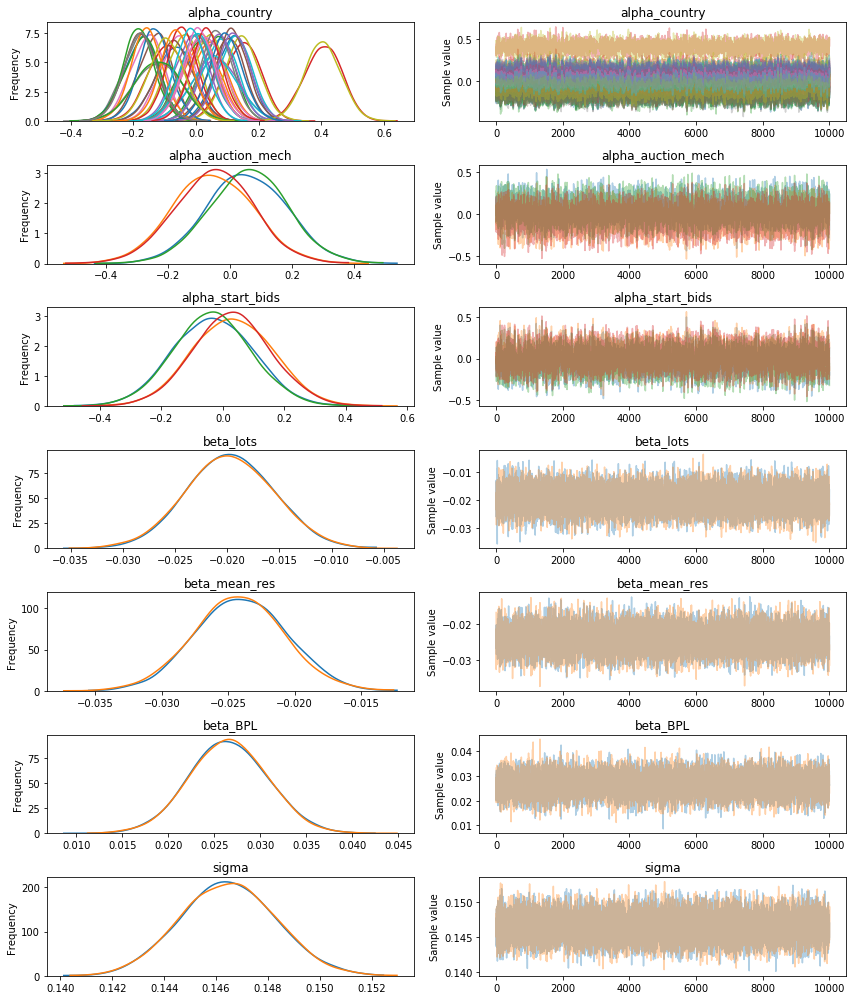

In [23]:
_ = pm.traceplot(ror_model_basic_trace)


#### In-Sample Prediction
Simulate predictions of alpha from the posterior distribution, conditional on observations of the input variables (as held within ror_model_basic). We do this for predictions both on 'model' and 'inverse transformed' values.

100%|██████████| 10000/10000 [02:00<00:00, 83.07it/s]
20000it [00:03, 5716.51it/s]


RMSE = 0.14577215191502527
Deviance = -3345.241301458775
% observations in 95.0% prediction range = 95.9880239520958


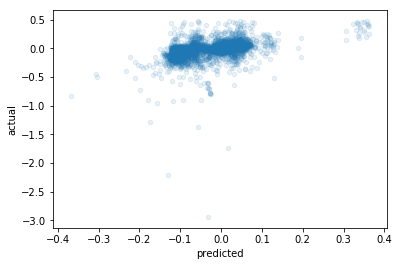

In [24]:
ror_model_basic_insamp = model_performance(
    y_train, ror_model_basic_trace, ror_model_basic, samples_=10000)

_ = (ror_model_basic_insamp
     .plot(kind='scatter', x='predicted', y='actual', alpha=0.1))


As above, but applying the inverse transform to the model's prediction to get to the 'natural' scale.

100%|██████████| 10000/10000 [01:59<00:00, 92.27it/s]
20000it [00:03, 6079.23it/s]


RMSE = 0.12283825363392
Deviance = -3345.241301458775
% observations in 95.0% prediction range = 95.9880239520958


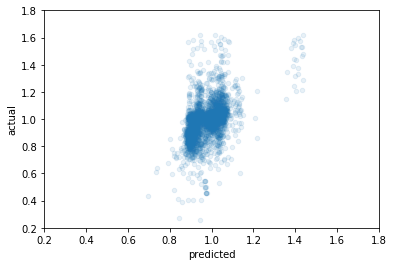

In [25]:
ror_model_basic_insamp_tfm = model_performance(
    y_train, ror_model_basic_trace, ror_model_basic, samples_=10000,
    y_inv_tfm=dvar_itfm)

_ = (ror_model_basic_insamp_tfm
     .plot(kind='scatter', x='predicted', y='actual', alpha=0.1,
           xlim=[0.2, 1.8], ylim=[0.2, 1.8]))


The model shows some great performance, but with some terrible estimates as well. We now take a look at the residuals on the 'model' scale, as a check to ensure that our choice of likelihood function was adequate and that there is no obvious multi-modality that may be due to a lack of informative independent variables to condition on.

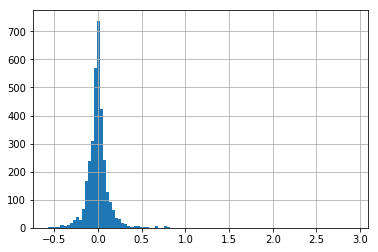

In [26]:
_ = (ror_model_basic_insamp['error']
     .hist(bins=100))


Looks like a nice Student-T distribution would better approximate the 'fat tails' we can see here.

#### Out-of-Sample Prediction

100%|██████████| 10000/10000 [01:59<00:00, 83.64it/s]
20000it [00:02, 7571.41it/s]


RMSE = 0.12583296622617093
Deviance = -867.0886187502891
% observations in 95.0% prediction range = 95.44910179640719


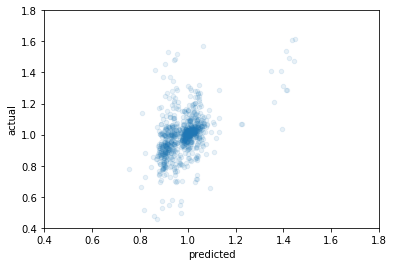

In [27]:
load_test_data()
ror_model_basic_outsamp = model_performance(
    y_test, ror_model_basic_trace, ror_model_basic, samples_=10000,
    y_inv_tfm=dvar_itfm)

_ = (ror_model_basic_outsamp
     .plot(kind='scatter', x='predicted', y='actual', xlim=[0.4, 1.8],
           ylim=[0.4, 1.8], alpha=0.1))


### Model Specification #2 - Weakly Regularising Priors and Robust Estimation
We adapt our basic model to use a Student-T likelihood for robustness / 'fat tails', with the same weakly regularising priors as for model #1. We have chosen a parametrisation for the degrees of freedom, $\nu$, that allows us to explore all possible values using only a small uniform interval. This will improve the performance of the Hamiltonian Monte Carlo (HMC) algorithm used to generate the Markov chains, by defending against the vanishing gradients along this dimension of the posterior distribution.

In [28]:
load_train_data()
ror_model_robust = pm.Model()

with ror_model_robust:

    # priors for unknown model parameters
    alpha_country = pm.Normal('alpha_country', mu=0, sd=0.25, shape=n_entities)
    alpha_auction_mech = pm.Normal(
        'alpha_auction_mech', mu=0, sd=0.25, shape=n_auction_mech)
    alpha_start_bids = pm.Normal('alpha_start_bids', mu=0, sd=0.25, shape=2)

    beta_lots = pm.Normal('beta_lots', mu=0, sd=0.25, shape=1)
    beta_mean_rsv = pm.Normal('beta_mean_res', mu=0, sd=0.25, shape=1)
    beta_BPL = pm.Normal('beta_BPL', mu=0, sd=0.25, shape=1)

    tau = pm.Uniform('tau', lower=0, upper=1)
    sigma = pm.HalfCauchy('sigma', beta=2)

    # expected value
    mu = (alpha_country[country] + alpha_auction_mech[auction_mech]
          + alpha_start_bids[start_bids] + beta_lots[0] * lots
          + beta_mean_rsv[0] * mean_rsv + beta_BPL[0] * BPL)

    # likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT('Y_obs', mu=mu, sd=sigma, nu=1/tau, observed=Y)


#### MAP Point Estimate
Use optimisation methods to get a point estimate for quick inspection.

In [29]:
ror_model_robust_map = pm.find_MAP(model=ror_model_robust)
ror_model_robust_map


logp = 3,075.5, ||grad|| = 1.1169: 100%|██████████| 252/252 [00:00<00:00, 777.13it/s] 


{'alpha_country': array([-0.02686339,  0.04487567, -0.00846237,  0.05521799,  0.19893756,
        -0.07386898, -0.1645338 , -0.12094909,  0.00090858, -0.02229346,
         0.02178788,  0.03322635,  0.02055602,  0.37410139, -0.05014549,
         0.04823568,  0.07645979, -0.12995374,  0.00990929,  0.05190637,
        -0.13528897,  0.01632026, -0.1283325 , -0.06409008, -0.01488674]),
 'alpha_auction_mech': array([0.01235511, 0.00041911]),
 'alpha_start_bids': array([0.00254362, 0.0102306 ]),
 'beta_lots': array([-0.00636439]),
 'beta_mean_res': array([-0.00397549]),
 'beta_BPL': array([0.00185397]),
 'tau_interval__': array(0.93989946),
 'sigma_log__': array(-3.12697307),
 'tau': array(0.71907935),
 'sigma': array(0.04385033)}

#### Markov Chain Monte Carlo Model Estimation
To get better diagnostics, we use Markov Chain Monte Carl (MCMC) techniques to simulate draw samples from the posterior distribution.

In [30]:
ror_model_robust_trace = run_or_load_mcmc(
    ror_model_robust, draws_=10000, tune_=2500)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


loading traces from: ../results/ror_model_robust_tune2500draw10000chains2.pkl
computing traces...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, tau, beta_BPL, beta_mean_res, beta_lots, alpha_start_bids, alpha_auction_mech, alpha_country]
Sampling 2 chains: 100%|██████████| 25000/25000 [49:30<00:00,  8.42draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


saving traces to: ../results/ror_model_robust_tune2500draw10000chains2.pkl


Compute the Gelman-Rubin statistic (r-hat) to check for chain convergence on the marginal parameter distributions (we are looking for r-hat values equal to 1).

In [31]:
pm.diagnostics.gelman_rubin(ror_model_robust_trace)


{'alpha_country': array([0.99995044, 0.99997525, 0.99995065, 0.999969  , 0.99996697,
        0.99995048, 0.99995288, 0.99995512, 0.99995316, 0.9999501 ,
        0.99995964, 0.99995591, 0.99995051, 0.99995064, 0.99995027,
        0.99995224, 0.99995057, 0.99995025, 0.99995304, 0.99995169,
        0.99995523, 0.99995943, 0.99995   , 0.99995458, 0.99995166]),
 'alpha_auction_mech': array([0.99998318, 0.99998819]),
 'alpha_start_bids': array([0.9999788 , 0.99997268]),
 'beta_lots': array([1.00004284]),
 'beta_mean_res': array([0.99995429]),
 'beta_BPL': array([0.99998223]),
 'tau': 1.0000043774607215,
 'sigma': 1.0000024412147968}

Compute the effective chain length for each parameter estimate (i.e. accounting for auto-correlation in the chains).

In [32]:
pm.diagnostics.effective_n(ror_model_robust_trace)


{'alpha_country': array([2505.0798829 , 2506.88034026, 2396.50675529, 2434.93424211,
        2640.21282997, 2403.34388253, 2354.33462045, 2374.27533859,
        2360.17151412, 2414.92144787, 2392.08274123, 2388.09773009,
        2459.98069031, 2772.0294108 , 2405.34409911, 2520.88123159,
        2423.95902826, 3048.96088855, 2373.3695546 , 2401.92508456,
        2438.89660027, 2386.97411431, 2393.97209875, 2443.05129327,
        2363.67663751]),
 'alpha_auction_mech': array([6696.75908489, 6689.77553627]),
 'alpha_start_bids': array([6680.9333335 , 6678.45872886]),
 'beta_lots': array([17765.87196331]),
 'beta_mean_res': array([15552.36226551]),
 'beta_BPL': array([16071.8553684]),
 'tau': 13458.163831622029,
 'sigma': 13200.529316711745}

It appears as if the effective number of samples for the average entity levels is relatively low. This is likely to be acceptable for computing means, but may require longer chains for computing intervals, etc.
Now check the trace plots for each parameter sampled from the posterior distribution, for each chain, to get a feel for how well the marginal distributions of each parameter have been explored.

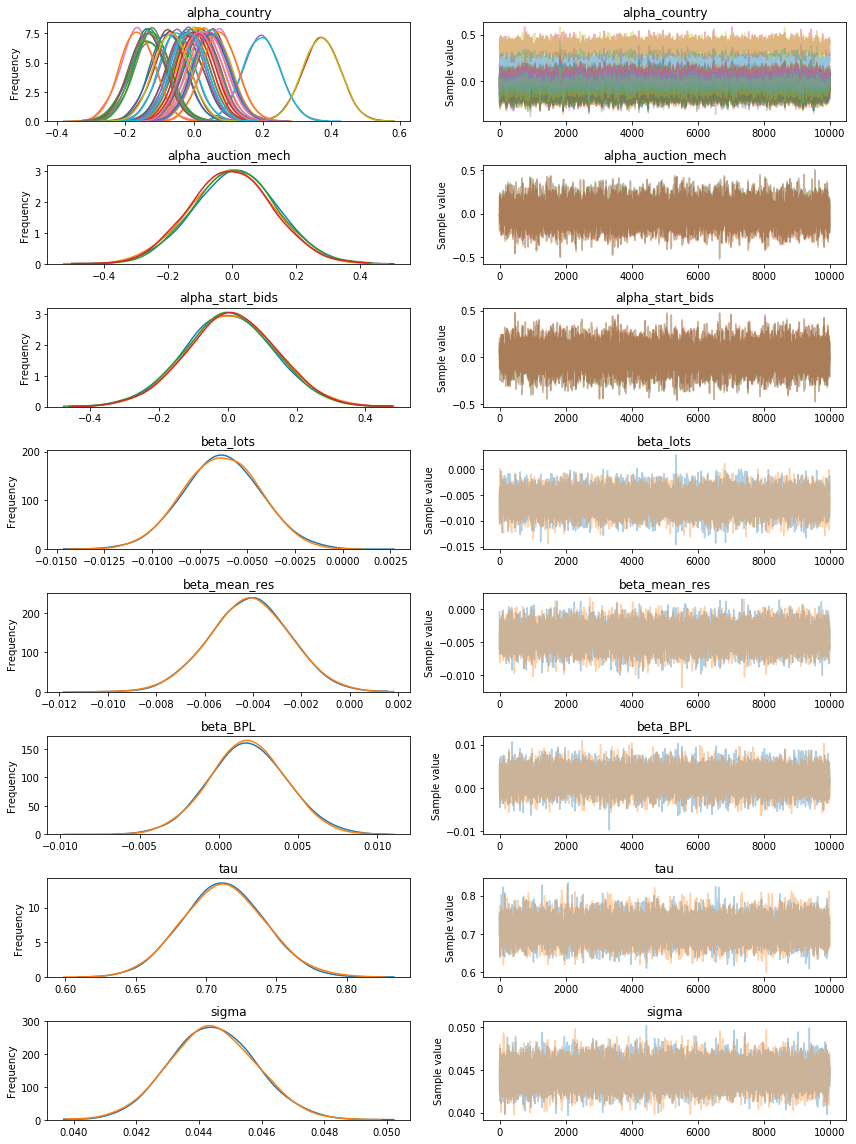

In [33]:
_ = pm.traceplot(ror_model_robust_trace)


#### In-Sample Prediction
Simulate predictions of alpha from the posterior distribution, conditional on observations of the input variables (as held within ror_model_robust), as before.

100%|██████████| 10000/10000 [02:04<00:00, 80.30it/s]
20000it [00:05, 3950.17it/s]


RMSE = 0.1580923850208118
Deviance = -6095.330175484192
% observations in 95.0% prediction range = 95.50898203592814


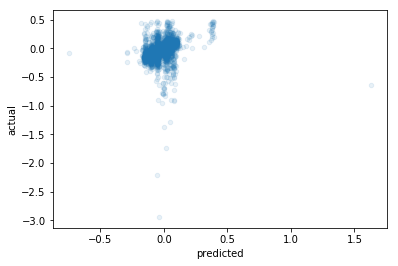

In [34]:
ror_model_robust_insamp = model_performance(
    y_train, ror_model_robust_trace, ror_model_robust, samples_=10000)

_ = (ror_model_robust_insamp
     .plot(kind='scatter', x='predicted', y='actual', alpha=0.1))


As above, but applying the inverse transform to the model's prediction to get to the 'natural' scale.

100%|██████████| 10000/10000 [02:10<00:00, 76.74it/s]
20000it [00:05, 3914.49it/s]


RMSE = 0.7509782454845553
Deviance = -6095.330175484192
% observations in 95.0% prediction range = 95.44910179640719


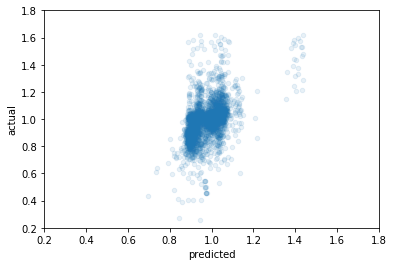

In [35]:
ror_model_robust_insamp_tfm = model_performance(
    y_train, ror_model_robust_trace, ror_model_robust, samples_=10000,
    y_inv_tfm=dvar_itfm)

_ = (ror_model_basic_insamp_tfm
     .plot(kind='scatter', x='predicted', y='actual', alpha=0.1,
           xlim=[0.2, 1.8], ylim=[0.2, 1.8]))


We take a look at the residuals again, just because it makes me comfortable.

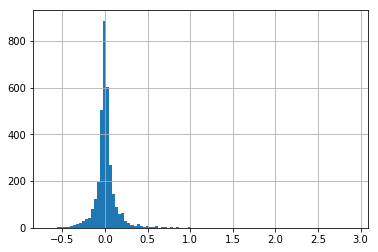

In [36]:
_ = (ror_model_robust_insamp['error']
     .hist(bins=100))


Looks like a nice Student-T distribution, just as we specified in our model! We now use the model to score the test dataset.

#### Out-of-Sample Prediction

100%|██████████| 10000/10000 [01:58<00:00, 84.15it/s]
20000it [00:03, 6387.49it/s]


RMSE = 0.13720954788615078
Deviance = -1484.5676859673283
% observations in 95.0% prediction range = 94.97005988023952


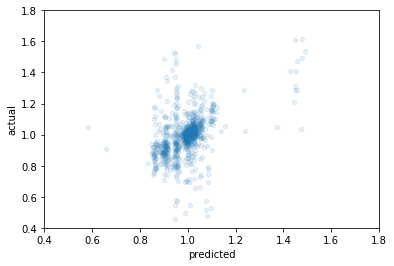

In [37]:
load_test_data()
ror_model_robust_outsamp = model_performance(
    y_test, ror_model_robust_trace, ror_model_robust, samples_=10000,
    y_inv_tfm=dvar_itfm)

_ = (ror_model_robust_outsamp
     .plot(kind='scatter', x='predicted', y='actual', xlim=[0.4, 1.8],
           ylim=[0.4, 1.8], alpha=0.1))


### Model Comparison and Selection
We will use WAIC to help select which model to choose for subsequent interpretation. WAIC estimates the OOS predictive accuracy of a model (also known as the deviance), using only the training data. We are also in the fortunate position that we have a test dataset that we can use in addition to WAIC (to compute the actual OOS deviance).

Unlike other Bayesian information criteria (such as AIC and DIC) - that are based on an asymptotic Normal approximation of the posterior density - WAIC should be suitable for comparing models with different likelihood functions. See Chapter 7 of 'Bayesian Data Analysis', by Andrew Gelman & Co. for more discussion.

In [38]:
load_train_data()
pm.stats.compare(
    {ror_model_basic: ror_model_basic_trace,
     ror_model_robust: ror_model_robust_trace},
    ic='WAIC')


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
1,-6047.92,47.41,0,0.85,160.28,0,0
0,-3274.91,70.33,2773.01,0.15,527.05,495.3,1


### Model Selection and Interpretation
The model with the lowest WAIC is the robust linear model. Furthermore, its actual OOS predictive performance, as measured by the OOS deviance, agrees with predicted OOS deviance as represented by WAIC. Perhaps most importantly, however, the distribution of the residuals are clearly leptokurtic, something which the Normal likelihood of the basic model cannot capture. To add to the weight of evidence for the robust model, we note that the Normal likelihood is a limiting case of the Student-T, as $\nu \to \infty$, and that **all** of the probability mass/density for $\nu$ is < 2. 

We now transform the parameter estimates back to the natural scales of the data and compute the sensitivities of the dependent variable to changes (deltas) in the independent variables. We do this for each independent variable at a time, holding all other variables at their average levels (which is equivalent to setting them to zero as they have been standardised).

Because we took the modelling decision to transform the dependent variable using the natural logarithm, the process of computing sensitivities is not trivial as it would have be otherwise. More specifically, a small change in the average level of an independent variable has a measurable change to the *arithmetic return* of the independent variable, as we derive below. 

We start with the expression for the expected value of RoR in the presence of a $\Delta z$ change in the standardised independent variables,

$$
\text{E}[RoR_{\Delta z_{i}}] = exp\left\{C + \sum_{i} \beta_{i} \Delta z_{i}\right\}
$$

where $C$ is equal to the sum of all constant (or intercept) terms in our model. Note that in the presence of no $\Delta z_{i}$ peturbations $\text{E}[RoR] = e^C$. We now consider the impact of only one peturbation at a time, such that,

$$
\text{E}[RoR_{\Delta z}] = f(\Delta z) =  e^{C + \beta \Delta z}
$$

remembering that the expected value of the standardised independent variables is 0. We can approximate $f(\Delta z)$ using a Taylor expansion, assuming that $|C + \beta \Delta x| < 1$,

$$
f(\Delta z) = \sum_{n = 0}^{\infty} \frac{(\Delta x)^n}{n!} \left( \frac{\partial f(z^{'})}{\partial z^{'}} \right)_{z^{i} = 0}
$$

If we only keep linear (first order) terms in $\Delta z$, then we have that,

$$
f(\Delta z) \approx e^C + e^C \beta \Delta x
$$

Remembering that in the presence of no $\Delta z_{i}$ peturbations, $\text{E}[RoR] = e^C$, we now have that 

$$
\frac{\text{E}[RoR]_{\Delta z_{i}}}{\text{E}[RoR]} - 1 = r^{\text{RoR}}_{\Delta z_i} = \beta \Delta z_i
$$

Given that we can easily express any deviation of the independent variable from its mean, in units of standard deviation (in its natural units), we are now in a position to perform a full sensitivity analysis of our model (based on point estimates of parameter values).

In [39]:
num_ivar = ['lots', 'avg_reserve', 'BPL']

param_names = (
    cat_col_levels['country']
    + cat_col_levels['auction_mech']
    + cat_col_levels['start_bids']
    + num_ivar
    + ['nu', 'sigma'])

param_est = pm.summary(ror_model_robust_trace)
param_est.index = param_names

param_est['std'] = np.hstack(
    [np.ones(29), model_data[num_ivar].std(), np.ones(2)])

param_est['delta_nat_unit'] = np.hstack(
    [np.ones(29), np.array([100, 1000, 1], dtype='float32'), np.zeros(2)])

param_est['delta_impact_pct'] = (
    100 * param_est['mean'] * param_est['delta_nat_unit'] / param_est['std'])

param_est['delta_impact_pct'] = (
    param_est['delta_impact_pct'].apply(lambda x: '{0:.2f}%'.format(x)))

results = param_est.drop(['sd', 'n_eff', 'Rhat', 'mc_error'], axis=1)
results


,mean,hpd_2.5,hpd_97.5,std,delta_nat_unit,delta_impact_pct
country_AE,-0.027387,-0.130104,0.072687,1.000000,1.0,-2.74%
country_AT,0.043048,-0.060067,0.143019,1.000000,1.0,4.30%
country_BE,-0.007446,-0.104102,0.093928,1.000000,1.0,-0.74%
country_BR,0.055852,-0.044253,0.155411,1.000000,1.0,5.59%
country_CH,0.197085,0.092583,0.301770,1.000000,1.0,19.71%
country_CZ,-0.075240,-0.178120,0.020478,1.000000,1.0,-7.52%
country_DE,-0.164376,-0.263988,-0.067797,1.000000,1.0,-16.44%
country_ES,-0.121475,-0.223702,-0.026850,1.000000,1.0,-12.15%
country_EU,0.000740,-0.095983,0.100056,1.000000,1.0,0.07%
country_FI,-0.021136,-0.120476,0.077813,1.000000,1.0,-2.11%


### Model Interrogation
Now that we have chosen a model that we believe is the most representative of the processes that led to the observed data, we can exploit the fact that this model is a *generative* model of these processes, start to ask detailed questions of it and stop relying on analyses of point estimates to answer complicated questions that these sorts of approximative analyses cannot address completely.

#### Analysis #1 - English Forward vs. Sealed Bid Auctions A/B Test
The first question that we will ask, are English Forward (EF) auction mechanisms perform better than Sealed Bid (SB) auction mechanisms. We already know that the *mean* (point estimates) of the EF and SB factors imply that EF auctions out-perform SB auctions *on average*, but these can only be taken at fact-value if there is correlation between the parameters (remember, these are also random variables). As we are now in a position to explicitly compute the differences and factor-in any dependency structure, we proceed with this approach.

P(EF-effect > SB-effect) = 0.93535
mean difference in RoR between EF and EB auctions = 0.013163163438340359


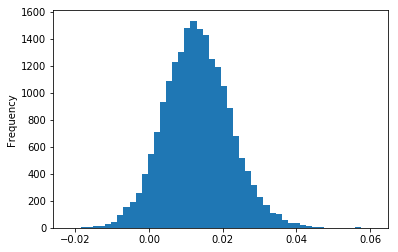

In [40]:
auction_mech_ab = pd.DataFrame(
    ror_model_robust_trace['alpha_auction_mech'], columns=['EF', 'SB'])

auction_mech_ab['diff'] = (
    dvar_itfm(auction_mech_ab['EF']) - dvar_itfm(auction_mech_ab['SB']))

prob_EF_gt_SB = (
    len(auction_mech_ab[auction_mech_ab['diff'] > 0]) / len(auction_mech_ab))

mean_diff = auction_mech_ab['diff'].mean()
print('P(EF-effect > SB-effect) = {}'.format(prob_EF_gt_SB))
print('mean difference in RoR between EF and EB auctions = {}'.format(mean_diff))

_ = auction_mech_ab['diff'].plot(kind='hist', bins=50)


It is conclusive that the EF auction mechanism *slightly_ outperforms SB auction mechanisms, even after controlling for for the number of bidders and variation in local market structure (i.e. trading country).

#### Analysis #2 - Quantifying the Impact of Bidders-Per-Lot
We would like to understand how BPL impacts the RoR for a lot, in isolation of all other variables. We achieve this by sampling form the the posterior predictive distribution while setting all other numerical variables to their average values (which is 0 as we have standardised the input data), and, by considering only the EF auction mechanism as used by the International country.

100%|██████████| 10000/10000 [01:59<00:00, 83.63it/s]


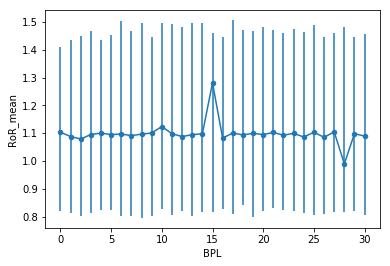

In [41]:
def BPL_control_data(n):
    # setup BPCc support
    BPL_mean = model_data['BPL'].mean()
    BPL_std = model_data['BPL'].std()
    BPL_range = np.linspace(0, n, n+1)
    BPL_range_stdised = (BPL_range - BPL_mean) / BPL_std

    # setup all other numerical variates at average/control levels
    all_other_vars = np.zeros(n+1)

    # setup categorical variabes to be EF auctions for International
    auction_mech_fix = np.zeros(n+1)
    country_fix = np.zeros(n+1) + 16

    # set values on model variables
    lots.set_value(all_other_vars)
    mean_rsv.set_value(all_other_vars)
    avg_start_bid.set_value(all_other_vars)
    BPL.set_value(BPL_range_stdised)
    auction_mech.set_value(auction_mech_fix.astype('int32'))
    country.set_value(country_fix.astype('int32'))
    start_bids.set_value(all_other_vars.astype('int32'))
    return BPL_range


BPL_support = BPL_control_data(30).reshape(-1, 1)
BPL_pp_dist = pm.sample_ppc(ror_model_robust_trace, model=ror_model_robust,
                            samples=10000)['Y_obs']

RoR_pp_mean = dvar_itfm(BPL_pp_dist.mean(axis=0).reshape(-1, 1))

RoR_pp_lwr = (
    RoR_pp_mean
    - dvar_itfm(np.percentile(BPL_pp_dist, 2.5, axis=0)).reshape(-1, 1))

RoR_pp_upr = (
    dvar_itfm(np.percentile(BPL_pp_dist, 97.5, axis=0)).reshape(-1, 1)
    - RoR_pp_mean)

BPL_control_df = pd.DataFrame(
    np.hstack([BPL_support, RoR_pp_mean, RoR_pp_lwr, RoR_pp_upr]),
    columns=['BPL', 'RoR_mean', 'RoR_lwr', 'RoR_upr'])

_ = (BPL_control_df
     .plot(kind='scatter', x='BPL', y='RoR_mean')
     .errorbar(x=BPL_control_df['BPL'], y=BPL_control_df['RoR_mean'],
               yerr=[BPL_control_df['RoR_lwr'], BPL_control_df['RoR_upr']]))


We can see that BPL has a neutral impact on performance - this is somewhat 'off' and needs to be further investigated. Maybe not all bidders are 'serious' and there are a lot of 'noisy' bids that are not contributing the efficiency of the price discovery process.

#### Analysis #3 - Posterior Predictive Check
As a check on the distributional properties of our model, we compare the posterior predictive distribution (below in blue), to the distribution of the test dataset (below orange, overlaid onto the posterior predictive distribution).

100%|██████████| 10000/10000 [02:15<00:00, 73.75it/s]


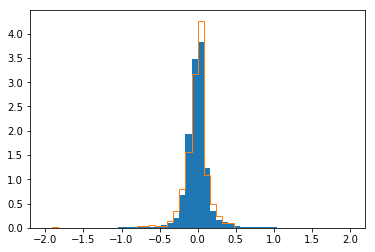

In [42]:
load_train_data()
pp_test_dist = pm.sample_ppc(
    ror_model_robust_trace, model=ror_model_robust, samples=10000)['Y_obs']

_ = plt.hist([pp_test_dist.ravel()], density=True, bins=50, histtype='bar',
             range=[-2, 2])

_ = plt.hist([y_test], density=True, bins=50, histtype='step', range=[-2, 2])


By visual inspection alone, it is possible to see that the distributions are a good match, but that the distribution of the data is more leptokurtic than that of the model's - i.e. the 'tails' of the data are fatter than the Student-T we have used for the likelihood.

## Conclusions
- English Forward auctions are likely to out-perform sealed bid auctions, on average;
- the number of lots offered has a small negative impact on price - e.g adding 100 more lots than usual will reduce prices by ~1.6%, on average;
- increases in the average lot value will have a small negative impact on price - e.g for every EUR 1,000 increase, prices will drop by ~8bps, on average;
- the number of bidders per-lot has an anomalously absent impact on RoR; and,
- there is a lot of variation in regional market micro-structure - e.g the factors that determine supply-and-demand dynamics (how much of what can be sold to whom, given competition), varies considerably on a regional basis.